# Initial configuration

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl")
from travel import init_travel
init_travel()

In [2]:
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig

VLM_NAME = "llava-hf/llava-1.5-7b-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

vlm = AutoModelForVision2Seq.from_pretrained(VLM_NAME, 
                                            quantization_config=bnb_config)
vlm.language_model.generation_config.temperature = None
vlm.language_model.generation_config.top_p = None
vlm.language_model.generation_config.do_sample = False

vlm_processor = AutoProcessor.from_pretrained(VLM_NAME)
vlm_processor.tokenizer.padding_side = "left"

visual_filter = None

/home/sstorks/.cache/pypoetry/virtualenvs/travel-nQET-zRt-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/sstorks/.cache/pypoetry/virtualenvs/travel-nQET-zRt-py3.10/lib/python3.10/site-packages/transformers/models/llava/configuration_llava.py:104: FutureWarning: The `vocab_size` argument is deprecated and will be removed in v4.42, since it can be inferred from the `text_config`. Passing this argument has no effect
  warnings.warn(
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Optional: set up visual filter

In [40]:
from PIL import Image
import spacy
import torch
from travel.model.grounding import SpatialVisualFilter, ImageMaskTypes, ContrastiveRegionFilter, VisualFilterTypes

visual_filter_mode = VisualFilterTypes.Spatial_NoRephrase
visual_filter = SpatialVisualFilter(rephrase_questions=False, mask_strength=1.0, mask_type=ImageMaskTypes.Darkness, device="cuda:0")

nlp = spacy.load('en_core_web_lg')

/home/sstorks/.cache/pypoetry/virtualenvs/travel-nQET-zRt-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Prepare important methods and output directory

In [41]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image
from pprint import pprint
from tqdm import tqdm

from travel.data.ego4d import Ego4DMistakeDetectionDataset
from travel.data.mistake_detection import MistakeDetectionExample, get_cutoff_time_by_proportion
from travel.data.vqa import VQA_PROMPT_TEMPLATES, VQAResponse, SUCCESSVQA_QUESTION_TEMPLATE, CAPTION_VQA_PROMPT_TEMPLATES, get_vqa_response_token_ids, VQAOutputs
from travel.data.vqg import VQGOutputs
from travel.model.mistake_detection import aggregate_mistake_probs_over_frames, DETECTION_FRAMES_PROPORTION

VQG2VQA_RESULTS_PATH = "/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results_222/vqa_mistake_detection/ego4d_debug250/llava-1.5-7b-hf/VQG2VQA_ego4d_debug250_llava-1.5-7b-hf_20240701115231/preds_heuristic_val.json"
preds_vqg2vqa = json.load(open(VQG2VQA_RESULTS_PATH, "r"))

# Gather up example dirs by example ID
dataset_cache_dir = Ego4DMistakeDetectionDataset.get_cache_dir("val",
                                                         mismatch_augmentation=True,
                                                         multi_frame=True,
                                                         debug_n_examples_per_class=500)
dataset_example_dirs = json.load(open(os.path.join(dataset_cache_dir, "dataset.json"), "r"))["example_dirs"]
dataset_example_dirs = {"/".join(d.split("/")[-3:]): d for d in dataset_example_dirs}

vqg_outputs = {}
vqa_answer_probs = defaultdict(list)

for pred in tqdm(preds_vqg2vqa.values()):
        
    example_id = pred['example']['example_id']
    example = Ego4DMistakeDetectionDataset.load_example_from_file(dataset_example_dirs[example_id])
    example.cutoff_to_last_frames(DETECTION_FRAMES_PROPORTION)
    assert len(example.frames) == len(pred['vqa'])

    # Extract the vqa list - just take the questions and answers for last frame
    # Create a figure with a subplot for each entry
    num_entries = len(pred['vqa'])
    num_questions = len(pred['vqa'][0])

    for frame_idx in range(len(pred['vqa'])):
        vqa_list = pred['vqa'][frame_idx]

        this_questions = []
        this_answers = []
        this_answer_probs = []
        for i, entry in enumerate(vqa_list):
            this_questions.append(entry['question'])
            this_answers.append(VQAResponse(int(entry['expected_answer'])).name)
            this_answer_probs.append({VQAResponse(int(k)): v for k, v in entry['answer_probs'].items()})
            
        if frame_idx == 0:
            vqg_outputs[example.procedure_id] = VQGOutputs(
                procedure_id=example.procedure_id,
                procedure_description=example.procedure_description,
                questions=this_questions,
                answers_str=this_answers,
            )
            
        vqa_answer_probs[example.example_id].append(this_answer_probs)
            
vqa_prompt_template = VQA_PROMPT_TEMPLATES[type(vlm)]
successvqa_question_template = SUCCESSVQA_QUESTION_TEMPLATE
response_token_ids = get_vqa_response_token_ids(vlm_processor.tokenizer)
vqg2vqa2successvqa_prompt_template = "USER: <image>\n{question1} ASSISTANT: {answer1} USER: {question2} ASSISTANT: {answer2} USER: " + f"{SUCCESSVQA_QUESTION_TEMPLATE} ASSISTANT: "

def generate_prompts(example: MistakeDetectionExample, add_caption_placeholder: bool=False):
    if add_caption_placeholder:
        raise NotImplementedError("caption_first mode not supported yet!")
        
    questions = []
    prompts = []
    answers = []
    frames = []
    successvqa_question = successvqa_question_template.format(step=example.procedure_description)

    expected_answer = VQAResponse["Yes"]

    for frame_idx, frame in enumerate(example.frames):
        if example.procedure_id in vqg_outputs:
            assert example.example_id in vqa_answer_probs
            
            q1 = vqg_outputs[example.procedure_id].questions[0]
            a1 = VQAResponse.Yes if vqa_answer_probs[example.example_id][frame_idx][0][VQAResponse.Yes] >= 0.5 else VQAResponse.No
            
            q2 = vqg_outputs[example.procedure_id].questions[1]
            a2 = VQAResponse.Yes if vqa_answer_probs[example.example_id][frame_idx][1][VQAResponse.Yes] >= 0.5 else VQAResponse.No
            
            prompt = vqg2vqa2successvqa_prompt_template.format(question1=q1, answer1=a1.name, question2=q2, answer2=a2.name, step=example.procedure_description)
        else:
            prompt = vqa_prompt_template.format(question=successvqa_question)

        questions.append(successvqa_question)
        prompts.append(prompt)
        answers.append(expected_answer)
        frames.append(frame)

    return questions, prompts, answers, frames


100%|██████████| 500/500 [00:10<00:00, 49.07it/s]


In [46]:
import datetime

from travel.constants import RESULTS_DIR
from travel.data.ego4d import Ego4DMistakeDetectionDataset

eval_partition = "val"
dataset = Ego4DMistakeDetectionDataset(data_split=eval_partition, 
                                                      mismatch_augmentation=True,
                                                      multi_frame=True,
                                                      debug_n_examples_per_class=250)

timestamp = datetime.datetime.now()
this_results_dir = os.path.join("ego4d_debug250", VLM_NAME.split("/")[-1], f"VQG2VQA2SuccessVQA_ego4d_debug250")
this_results_dir += f"_{VLM_NAME.split('/')[-1]}"
if visual_filter is not None:
    this_results_dir += f"_spatial_norephrase1.0"
this_results_dir += f"_{timestamp.strftime('%Y%m%d%H%M%S')}"
this_results_dir = os.path.join(RESULTS_DIR, "vqa_mistake_detection", this_results_dir)
os.makedirs(this_results_dir)

Run VQA:

In [47]:
from travel.model.mistake_detection import MISTAKE_DETECTION_STRATEGIES
from travel.model.vqa import run_vqa_for_mistake_detection

vqa_outputs = run_vqa_for_mistake_detection(eval_dataset=dataset,
                                            vlm=vlm,
                                            vlm_processor=vlm_processor,
                                            generate_prompts=generate_prompts,
                                            n_prompts_per_frame=1,
                                            visual_filter_mode=visual_filter_mode if visual_filter is not None else None,
                                            visual_filter=visual_filter,
                                            nlp=nlp if visual_filter is not None else None,
                                            cache_dir=this_results_dir,
                                            n_workers=1,
                                            worker_index=0,
                                            vqa_batch_size=4)

running detection (cuda:0): 100%|██████████| 17/17 [04:12<00:00, 14.85s/it]

running detection (cuda:0): 100%|██████████| 17/17 [04:12<00:00, 14.88s/it]

running VQA (cuda:0): 100%|██████████| 249/249 [02:53<00:00,  1.43it/s]

running detection (cuda:0): 100%|██████████| 17/17 [04:16<00:00, 15.06s/it]

running detection (cuda:0): 100%|██████████| 17/17 [04:16<00:00, 15.11s/it]

running VQA (cuda:0): 100%|██████████| 250/250 [02:53<00:00,  1.44it/s]

running detection (cuda:0): 100%|██████████| 9/9 [02:05<00:00, 13.92s/it]

running detection (cuda:0): 100%|██████████| 9/9 [02:04<00:00, 13.89s/it]

running VQA (cuda:0): 100%|██████████| 123/123 [01:24<00:00,  1.46it/s]

gathering VQA outputs (cuda:0): 100%|██████████| 100/100 [00:18<00:00,  5.40it/s][A
chunks (cuda:0): 3it [31:33, 631.19s/it]                       


Incorporate probabilities of individual question answers and calculate metrics:

In [48]:
from copy import deepcopy
new_vqa_outputs = deepcopy(vqa_outputs)
for example_idx in tqdm(range(len(new_vqa_outputs))):
    for frame_idx in range(len(new_vqa_outputs[example_idx])):
        this_probs = []
        for question_probs in vqa_answer_probs[vqa_outputs[example_idx][frame_idx][0].example_id][frame_idx]:
            this_probs.append(max(question_probs.values()))
        new_yes_prob = new_vqa_outputs[example_idx][frame_idx][0].answer_probs[VQAResponse.Yes]
        for p in this_probs:
            new_yes_prob += p
        new_yes_prob /= 3.0
        answer_probs = {VQAResponse.Yes: new_yes_prob, VQAResponse.No: 1.0 - new_yes_prob}
        new_vqa_outputs[example_idx][frame_idx][0].answer_probs = answer_probs
    
evaluator = MISTAKE_DETECTION_STRATEGIES["heuristic"](dataset, new_vqa_outputs)
mistake_detection_preds, metrics = evaluator.evaluate_mistake_detection()
print(f"Mistake Detection Metrics ({eval_partition}, Detection Threshold={metrics['best_threshold']}):")
pprint(metrics[metrics['best_threshold']])

evaluating mistake detection at threshold 1.0: 100%|██████████| 500/500 [00:09<00:00, 52.85it/s]

Mistake Detection Metrics (val, Detection Threshold=0.35):
{'accuracy': 0.662,
 'f1': 0.6817325800376648,
 'false_negative_rate': 0.276,
 'false_positive_rate': 0.4,
 'precision': 0.6441281138790036,
 'recall': 0.724}


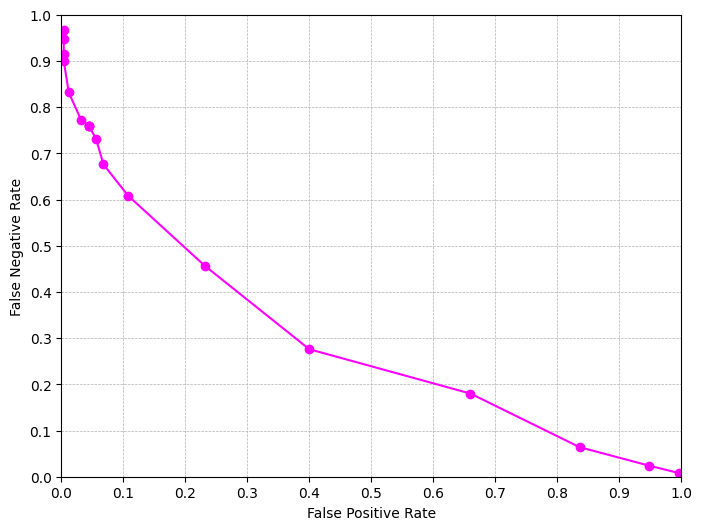

In [49]:
from travel.model.mistake_detection import compile_mistake_detection_preds, generate_det_curve

metrics_filename = f"metrics_heuristic_{eval_partition}.json"
json.dump(metrics, open(os.path.join(this_results_dir, metrics_filename), "w"), indent=4)

preds = compile_mistake_detection_preds(dataset, vqa_outputs, mistake_detection_preds, image_base_path=this_results_dir)
preds_filename = f"preds_heuristic_{eval_partition}.json"
json.dump(preds, open(os.path.join(this_results_dir, preds_filename), "w"), indent=4)

det_filename = f"det_heuristic_{eval_partition}.pdf"
generate_det_curve(metrics, os.path.join(this_results_dir, det_filename))